# MaxCut QAOA Implementation

Welcome to our Quantum Approximate Optimization Algorithm (QAOA) implementation tutorial for the MaxCut problem! This tutorial is designed to provide you with a hands-on understanding of how to apply QAOA using Qrisp to solve the MaxCut optimization problem.

To refresh your memory, [Maximum Cut, or MaxCut for short](https://en.wikipedia.org/wiki/Maximum_cut) involves dividing the nodes of a graph into two groups such that the number of edges between the groups is maximized. It has applications in various fields, including computer science, operations research, and statistical physics.

In this interactive tutorial, we'll first tackle the MaxCut problem to build a solid QAOA foundation. You'll be guided to learn how to formulate the problem for QAOA, implement the actual algorithm, and interpret the results.

Whether you're a quantum computing novice or an experienced algorithm developer checking out this remarkable new framework, you may have observed that virtually every other quantum programming framework and their quantum grandmother has implemented QAOA for MaxCut in a similar manner (authors used irony, it was super effective). We'll go one step further and showcase on why using the Qrisp QAOA module and its [QAOAProblem class](/reference/QAOAProblem) **is** a no-brainer when it comes to simplicity of implementation as well as the speed of the optimization itself.

## Your very first QAOA layer

Let's start slowly with deepening the understanding of QAOA at its core - one layer of the algorithm and see how it looks like. We start with importing necessary quantum gates, as well as `networkx`, which is a package for creating and manipulating graphs. In this block of code you also define the angle parameters $\gamma$ and $\beta$:

In [17]:
from qrisp import QuantumVariable, h, barrier, rz, rx, cx
import networkx as nx
from sympy import Symbol

G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
#nx.draw(G, with_labels=True)
N = G.number_of_nodes()

Feel free to play around with this block of code changing the graph through the number of nodes, the edges connecting them, and print the result by uncommenting ``nx.draw(G, with_labels=True)``.

Next thing on our list is defining the MaxCut cost operator and the mixer. Taking a peek in the appendices section of Hadfield's paper, we see, the MaxCut phase separator we have to implement is defined as
$$U_P=e^{-i\gamma_pH_P}=\e^{-i\gamma_p\sum_{ij\in E}(-Z_iZ_j)}.$$ Instead of using the `ZZ` gate, we will perform the same operation using only elementary gates.

In [18]:
gamma = Symbol('γ')

def apply_cost_operator(qv, gamma):
    for pair in list(G.edges()):
        cx(qv[pair[0]], qv[pair[1]])
        rz(2 * gamma, qv[pair[1]])
        cx(qv[pair[0]], qv[pair[1]])
        barrier(qv)
    return qv

The first line starts a loop over all edges in the graph ``G``. Each edge is a pair of nodes, which we refer to as ``pair[0]`` and ``pair[1]``. We then apply a controlled-X (CNOT) gate to the pair of qubits before applying a rotation around the Z-axis by an angle of $2\gamma$ to the second qubit in the pair. At the end we apply another CNOT gate to the pair of qubits.

As suggested in the table of our QAOA theoretical overview, we are using the ``rx`` gate as the mixer.

In [19]:
beta = Symbol('β')

def apply_mixer(qv, beta):
    for i in range(0, N):
        rx(2 * beta, qv[i])
    barrier(qv)
    return qv

With these two functions at our disposal we can now implement our first QAOA layer and `print(qv.qs)` it.

In [20]:
qv_1 = QuantumVariable(N)
h(qv_1)
apply_cost_operator(qv_1, gamma)
apply_mixer(qv_1, beta)
print(qv_1.qs)

QuantumCircuit:
---------------
        ┌───┐                      ░                       ░                 »
qv_1.0: ┤ H ├──■───────────────■───░───■───────────────■───░─────────────────»
        ├───┤  │               │   ░   │               │   ░ ┌───┐┌─────────┐»
qv_1.1: ┤ H ├──┼───────────────┼───░───┼───────────────┼───░─┤ X ├┤ Rz(2*γ) ├»
        ├───┤  │               │   ░   │               │   ░ └─┬─┘└─────────┘»
qv_1.2: ┤ H ├──┼───────────────┼───░───┼───────────────┼───░───┼─────────────»
        ├───┤┌─┴─┐┌─────────┐┌─┴─┐ ░   │               │   ░   │             »
qv_1.3: ┤ H ├┤ X ├┤ Rz(2*γ) ├┤ X ├─░───┼───────────────┼───░───■─────────────»
        ├───┤└───┘└─────────┘└───┘ ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░                 »
qv_1.4: ┤ H ├──────────────────────░─┤ X ├┤ Rz(2*γ) ├┤ X ├─░─────────────────»
        └───┘                      ░ └───┘└─────────┘└───┘ ░                 »
«              ░                       ░                       ░      »
«qv_1.0: ──────░───────────

Applying hadamard gates on ``qv`` prepares the initial state for our system - the superposition state $|s\rangle$ .

If you have executed all the preceding cells correctly, you should have been able to print and examine the circuit of the initial QAOA layer. You may notice a pattern in the phase separator section of the circuit, which links two qubits corresponding to a specific pair of nodes in ``G`` that are connected by an edge (commencing flashback: `G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])`). The use of barriers between such pairs facilitates a more intuitive understanding of the phase separator unitary's inner workings.

We've used the parameters $\gamma$ and $\beta$ symbolically, without assigning specific numerical values to them. In the next section we will build on top of the first layer, assign values to the angle parameters and iteratively optimize their value with each additional layer (SPOILER ALERT). 

As we add more layers to our QAOA circuit, the values of $\gamma$ and $\beta$ are refined, leading us closer to the optimal solution. This iterative improvement is the core of what makes QAOA such a powerful tool.

## MaxCut QAOA implementation

Putting focuss on the problem at hand (MaxCut if you're just scrolling through and not paying that much attention) it is reasonable to ask ourselves what will be the objective that we want to optimize. 

As the name suggests, we are looking for a cut going through as much edges as possible. It's therefore crucial to count the amount of cuts we cut through (I'll cut it out now) by checking if the nodes ``i`` and ``j`` belong to different groups. If they are, the edge $(i,j)$ is cut and added to the total.

In [21]:
def maxcut_obj(x):                              
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:                         
            cut -= 1
    return cut

This optimization objective is important for the last building blocks described in the theoretical overview we haven't mentioned yet - the cost function. The cost function is important for keeping track of the energy of the system:

In [22]:
def maxcut_cost_funct(meas_res):
    energy = 0
    for meas, p in meas_res.items():
        obj_for_meas = maxcut_obj(meas)
        energy += obj_for_meas * p
    return energy

We loop over the measurement  in ``meas_res``. Each solution is represented by a string of 1 and 0 in ``meas`` with probability ``p`` keeping score in how likely a particular solution appears. 

For each such solution the cost is calculated using the ``maxcut_obj`` returning the number of cut edges. At the end, ``maxcut_cost_funct`` calculates the average "quality" of a set of solutions to the MaxCut problem. A lower average energy means that, on average, the solutions are better - they cut more edges.

This is now nearly all the building blocks we need in order to run QAOA and start optimizing. Well, after we add more layers to our algorithm, that is.

In [23]:
p = 3

def apply_p_layers(qv, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    h(qv)                                        
    for i in range(p):                           
        apply_cost_operator(qv, gamma[i])
        apply_mixer(qv, beta[i])
    barrier(qv)
    return qv

With our $p$-layered algorithm in hand there is one last piece of the puzzle: the objective function, which we need to generate in order to calculate the average energy of the resulting solutions. Oh, and it features the angle parameters $\gamma$ and $\beta$, which we combine in one list ``theta``. The solutions we get depend on the values of the angle parameters.

In [24]:
def quantum_objective(theta):
    qv_p = QuantumVariable(N)
    beta = theta[:p]
    gamma = theta[p:]
    qv = apply_p_layers(qv_p,beta, gamma)
    results = qv.get_measurement()
    return maxcut_cost_funct(results)

We can finally finish combine all the pieces of the mosaic and have it appraised by a professional - a classical optimizer. Running it online might take a second so we would like to encourage you to download Qrisp and try out for yourself!

We first reset the initial state and randomize it in a list where the first $p$ values correspond to $\beta$ and the second one to $\gamma$. It has finally come the time to inclute the COBYLA optimiser, which will return the optimal parameters that minimze our objective function. This is done using the ``minimize`` method, which adjusts the parameters iteratively until it finds the best ones.

Then, once we have our optimal parameters, we apply QAOA one more time to get our final set of solutions (``counts``), before finding the best solution by looking for the one with the lowest energy. Finally, we visualize our solution by coloring the nodes of our graph according to which group they belong to in the best solution.

Best string: 11100 with cut: 6                                                       


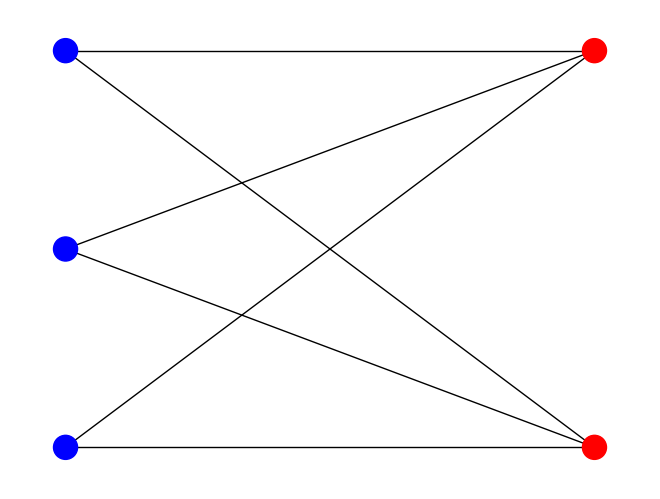

In [25]:
import numpy as np
from scipy.optimize import minimize
from operator import itemgetter

init_point = np.pi * np.random.rand(2 * p)

res_sample = minimize(quantum_objective, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumVariable(N)
qv = apply_p_layers(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = qv_p.get_measurement()

best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

And voila! We just solved the MaxCut problem using a relatively straightforward brute force approach. While this method can be effective, it's not the most efficient or elegant way to tackle this problem, and other problem instances with more complex objectives, mixers, or both. 

That's where our QAOAProblem class comes in. This class simplifies the process of running QAOA by introducing modularity, without sacrificing the generality of whichever problem instance we're dealing with. As we move forward in this tutorial, you'll have the opportunity to try it out for yourself.

## QAOAProblem. Enough said.

🎶 Enough chit chat, you ain't got all day - let's get to it: QAOAProblem, lead the way! 🎶

Taking the essential building blocks from [QAOAnsatz](https://arxiv.org/abs/1709.03489) into account, we built the [QAOAProblem class](/reference/QAOA) with modularity in mind. We gathered and improved the functions shown in the example above and created a powerfull architecture with which it's easy to implement various problem instances of varying complexity. In this tutorial we focus on using QAOAProblem, with extensive documentation being available [here](/reference/QAOA).

We start with renaming our quantum argument `qv` to a more general `qarg` because more often than not we'll combine [QuantumVariables](/reference/QuantumVariable) into a [QuantumArray](/reference) to make implementations of other problem instances more efficient.

In [26]:
qarg = QuantumVariable(len(G))

depth = 3

BEHOLD, THE POWER OF QRISP!

In [27]:
from qrisp.qaoa import QAOAProblem, RX_mixer

maxcut_instance = QAOAProblem(apply_cost_operator, RX_mixer, maxcut_cost_funct)

res = maxcut_instance.run(qarg, depth, max_iter = 50) # runs the simulation

And that's pretty much it, really. Apart from visualizing the results again.

Best string: 11100 with cut: 6
QAOA solution:  11100


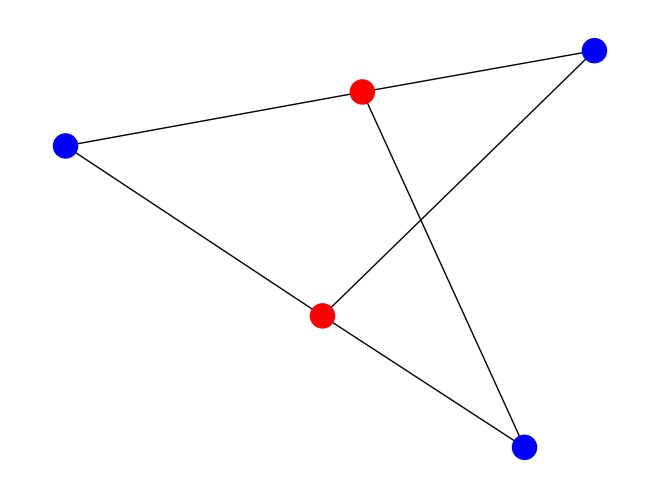

In [28]:
best_cut, best_solution = min([(maxcut_obj(x),x) for x in res.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

res_str = list(res.keys())[0]
print("QAOA solution: ", res_str)
best_cut, best_solution = (maxcut_obj(res_str),res_str)

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors)

After thorough comparison certainly made after running both approaches for different graph topologies you are in position to be the judge regarding which approach is qrispier.

## Benchmarking the performance

Lucky for you, the tutorial is not over since there is one more important functionality we would like to show you - the [benchmark](/reference/qrisp.qaoa.QAOAProblem.benchmark) method of our QAOA module. This method allows you to observe the performance of your simulation: 

- get insights about the approximation ratio for each run together with the average approximation ratio with its variance, 
- obtain total circuit depth, 
- obtain the overall quantum volume, 
- and rank the results for different depths, amount of shots, as well as iterations.

Let's show how easy benchmarking QAOA is using Qrisp:

In [29]:
print('RND')

benchmark_data = maxcut_instance.benchmark(qarg = QuantumVariable(len(G)),
                       depth_range = [1,2,3,4,5],
                       shot_range = [1000, 10000],
                       iter_range = [100, 200],
                       optimal_solution = '00011',
                       repetitions = 1,
                       init_type='random'
                       )

temp = benchmark_data.rank(print_res = True)

_,rndFO=benchmark_data.evaluate()

print('Approximation ratio: ',sum(rndFO)/len(rndFO))
print("Variance: ",np.var(rndFO))

RND
Rank  approx_ratio Overall QV   p    QC depth   QB count  Shots   Iterations         
0     0.985e+0     5.4000e+8    5    54         5         10000   200       
1     0.977e+0     2.7000e+8    5    54         5         10000   100       
2     0.951e+0     4.4000e+8    4    44         5         10000   200       
3     0.944e+0     1.7000e+8    3    34         5         10000   100       
4     0.943e+0     3.4000e+7    3    34         5         1000    200       
5     0.921e+0     2.7000e+7    5    54         5         1000    100       
6     0.915e+0     2.2000e+7    4    44         5         1000    100       
7     0.902e+0     4.4000e+7    4    44         5         1000    200       
8     0.865e+0     2.4000e+7    2    24         5         1000    200       
9     0.821e+0     1.7000e+7    3    34         5         1000    100       
10    0.819e+0     5.4000e+7    5    54         5         1000    200       
11    0.818e+0     1.2000e+7    2    24         5         1000 

In the above example we obtain the list of results for the approximation ratio for various depths of QAOA ranging from 1 to 5. We run the benchmark for both 1000, and 10000 shots (the latter number is to avoid sampling of the solution); and for 100 and 200 iterations of the optimizer. Since QAOA is probabilistic every run is unique so it's important to run more repetitions for clearer insights.

It is important to note that in order to do the benchmark, one has to already know the optimal solution in order to calculate the optimal energy, and through that, the approximation ratio.

As expected, on average the runs with higher depths yield better approximation ratio (with some outliers, of course). 

The ``print('RND')`` was used because since the 0.4 update we have also included the [TQA warm-start initialization](https://arxiv.org/abs/2101.05742), which can be used within the [benchmark](/reference/qrisp.qaoa.QAOAProblem.benchmark) method by setting ``init_type='tqa'``. Let's try benchmarking this approach as well:

In [30]:
print('TQA')

benchmark_data = maxcut_instance.benchmark(qarg = QuantumVariable(len(G)),
                        depth_range = [1,2,3,4,5],
                        shot_range = [1000, 10000],
                        iter_range = [100, 200],
                        optimal_solution = '00011',
                        repetitions = 1,
                        init_type='tqa'
                        )

temp = benchmark_data.rank(print_res = True)

_,tqaFO=benchmark_data.evaluate()

print('Approximation ratio: ',sum(tqaFO)/len(tqaFO))
print("Variance: ",np.var(tqaFO))

TQA
Rank  approx_ratio Overall QV   p    QC depth   QB count  Shots   Iterations         
0     0.992e+0     5.4000e+8    5    54         5         10000   200       
1     0.990e+0     2.2000e+8    4    44         5         10000   100       
2     0.988e+0     2.2000e+7    4    44         5         1000    100       
3     0.988e+0     4.4000e+8    4    44         5         10000   200       
4     0.986e+0     1.7000e+7    3    34         5         1000    100       
5     0.983e+0     4.4000e+7    4    44         5         1000    200       
6     0.976e+0     2.7000e+8    5    54         5         10000   100       
7     0.967e+0     1.7000e+8    3    34         5         10000   100       
8     0.951e+0     5.4000e+7    5    54         5         1000    200       
9     0.950e+0     3.4000e+8    3    34         5         10000   200       
10    0.949e+0     2.7000e+7    5    54         5         1000    100       
11    0.929e+0     2.4000e+7    2    24         5         1000 

Again, since QAOA is probabilistic, every run returns different results.

As we can see, the TQA initialization tends to return better approximation ratios more consistently. Feel free to play around with the [benchmark](/reference/qrisp.qaoa.QAOAProblem.benchmark) method (or leave it running over night) to try and compare the two approaches further.

## Summary and motivation

To shortly summarize, in order to implement QAOA with QAOAProblem one needs to specify the problem using the following recipe 

I. define **CLASSICAL COST FUNCTION** of the problem you want to implement: ``maxcut_cost_funct(counts)``, 
II. define the **INITIAL STATE** if it is not the superposition, which is set by default,  
III. define **COST OPERATOR aka PHASE SEPARATOR** (or use the ones specified in [From QAOA to QAOA](https://arxiv.org/abs/1709.03489)) like ``apply_cost_operator`` above, and 
IV. select **MIXER** from the [assortment we provide and list here](/reference/MIXers).

Let's condense all of the above, and implement QAOA for MaxCut one last time in one block of code

QAOA solution:  11100                                                                


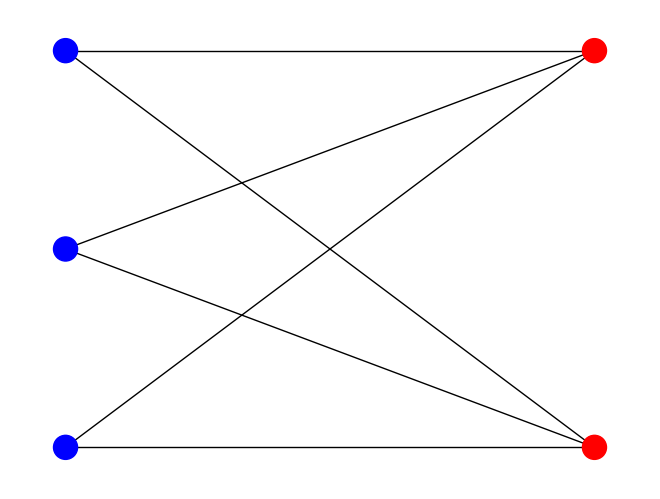

In [31]:
from qrisp import QuantumArray, QuantumVariable
from qrisp.qaoa import QAOAProblem, maxcut_obj, create_maxcut_cl_cost_function, create_maxcut_cost_operator, RX_mixer
import networkx as nx
from operator import itemgetter

G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])

qarg = QuantumVariable(len(G))

depth = 5

maxcut_instance = QAOAProblem(create_maxcut_cost_operator(G), RX_mixer, create_maxcut_cl_cost_function(G))

res = maxcut_instance.run(qarg, depth, max_iter = 50)

best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in res.keys()], key=itemgetter(0))

res_str = list(res.keys())[0]
print("QAOA solution: ", res_str)
best_cut, best_solution = (maxcut_obj(res_str,G),res_str)

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

You've got to admit that this is pretty cool, clean and qrispy, right?! 

If you are still not convinced, we provide a more complex problem instance in the next tutorial while also showcasing and putting some unique functionalities of Qrisp to the test. Let's make this transition a little more dramatic by saying that it's time to put our money where out mouths are (this is funny, because Qrisp is open source) and put this recipe to the test tackling the problem class which generalizes MaxCut: [Max-$\kappa$-Colorable Subgraph](/reference/MkCSQAOA).